# Tutorial 1: Generating a List of Experiments

In this tutorial, we will use the `generate_experiment` function from `tools.setup` to create a list of quantum experiments.
We will also visualize density matrix and circuits.

In [1]:
from tools.setup import generate_experiment
import qutip as qt
import numpy as np
import jax.numpy as jnp
from tools.processing import process_data,  flatten_list, parse_circuit_to_qobj, data_predict_from_rho_sampled, prepare_state

c:\Users\anike\anaconda3_\envs\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we generate circuit texts for selective elements. To process the full density matrix, `wanted_index` should contain the full first row, e.g., `[(0,0), (0,1), ..., (0,2**N-1)]`.



Wanted Indexes [(0, 0), (0, 3)] corresponds to these Selective Blocks: [0, 3]

********************
Selective Block 0

Wanted Elements [(0, 0)]

Selective elements in block [(0, 0), (1, 1), (2, 2), (3, 3)]

Pauli Observables:
  Even-Y set (E): ['II', 'IZ', 'ZI', 'ZZ']
  Odd-Y set  (O): []

SEEQST circuit text:
  Circuit 1: ['']

Non-entangling cirucits:
['']
********************
Selective Block 3

Wanted Elements [(0, 3)]

Selective elements in block [(0, 3), (1, 2), (2, 1), (3, 0)]

Pauli Observables:
  Even-Y set (E): ['XX', 'YY']
  Odd-Y set  (O): ['XY', 'YX']

SEEQST circuit text:
  Circuit 1: (CNOT:0,1)(RY90:0)
  Circuit 2: (CNOT:0,1)(RX90:0)

Non-entangling cirucits:
['(RY90:0)(RY90:1)', '(RY90:0)(RX90:1)', '(RX90:0)(RY90:1)', '(RX90:0)(RX90:1)']


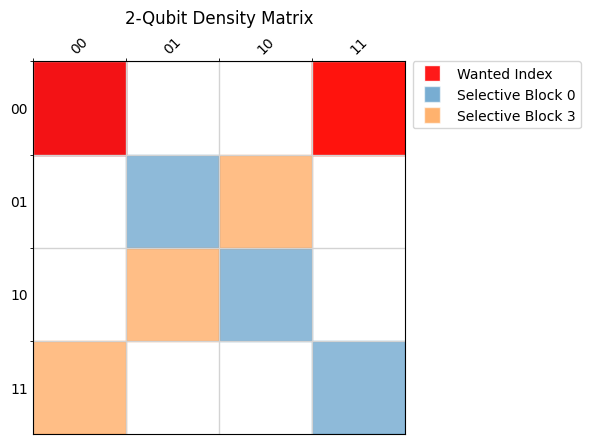

In [2]:
# Number of qubits in the quantum system
N = 2

# List of targeted elements in the density matrix
wanted_index = [(0, 0), (0, 3)]

# Options for printing and visualization. Set any of these to True to enable output.
options = {
    "density matrix plot": True,   # Plot the density matrix
    "wanted elements": True,       # Display the specified elements in the density matrix
    "selective elements": True,    # Highlight selective elements in the density matrix
    "circuits text": True,         # Show experiment circuits in text form
    "non entangling circuits text": True,  # Show non-entangling circuit descriptions
    "observable": True             # Display observables used in the experiment
}

# Generate experiment:
# 1. Identify selective blocks corresponding to the wanted elements.
# 2. Generate circuit lists in both text format and Qiskit-compatible format.
# 3. Generate circuit lists that do not require entangling gates, in both text and Qiskit format.
selective_blocks, sel_circ_text, sel_circ_text_non_entangle, sel_circ_qiskit, non_e_circ_qiskit, plot_rho = generate_experiment(wanted_index, N, options)

# Note: The function avoids default circuit implementations. Users should design their own circuits
# based on their specific system connectivity.

Selective Block: 0
Circuit 1:


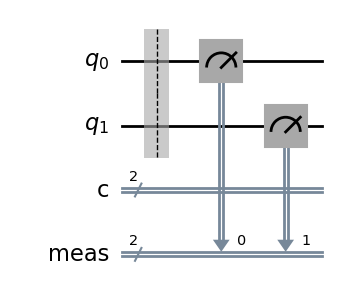

In [3]:
# Plot SEEQST Circuits
# Displaying the circuits for selective blocks 
for i, block in enumerate(selective_blocks[:1]):  # Iterate over the first selective block only
    print("Selective Block:", block)
    print("Circuit 1:")
    display(sel_circ_qiskit[i][0].draw('mpl'))
    
    # If the block is non-trivial (not diagonal), print a second circuit
    if block != 0:
        print("Circuit 2:")
        display(sel_circ_qiskit[i][1].draw('mpl'))

# Tutorial 2: Processing Data

In this tutorial, we will generate synthetic (fake) data and process it using the default implementation of circuits.
First, we use circuits that require entanglement, followed by circuits that do not require entanglement.

`sel_circ_text` is a list of circuit texts for selective blocks that require entangling gates. You can process data for individual blocks or several blocks combined. 
To process without entangling gates, just replace `sel_circ_text` with `sel_circ_text_non_entangle`.

In [4]:
# Display generated circuit texts
print("Circuits requiring entangling gates:")
print(sel_circ_text)
print("Circuits without entangling gates:")
print(sel_circ_text_non_entangle)

Circuits requiring entangling gates:
[[''], ['(CNOT:0,1)(RY90:0)', '(CNOT:0,1)(RX90:0)']]
Circuits without entangling gates:
[[''], ['(RY90:0)(RY90:1)', '(RY90:0)(RX90:1)', '(RX90:0)(RY90:1)', '(RX90:0)(RX90:1)']]


In [5]:
# Convert circuit text to JAX arrays
# Selective circuit texts - can be modified to improve efficiency
circuits = flatten_list(sel_circ_text)  # Requires CNOT gates

# circuits = flatten_list(sel_circ_text_non_entangle) # Uncomment to use non-entangling circuits

# Convert circuit text to unitary matrices
unitaries = parse_circuit_to_qobj(circuits, N)

# Convert Qobj to JAX numpy arrays
unitaries_jnp = jnp.array([uni.full() for uni in unitaries])

In [6]:
# Define ideal rho using a preparation circuit
initial_text = "(RX90:0)(RX90:1)(RX90:2)"
rho_ideal = prepare_state(initial_text, N=3)  # Prepare using circuit text

# Alternatively, generate a random ideal density matrix
rho_ideal = qt.rand_dm([[2]*N])  # Random density matrix

# Fake Data Generation (No noise)
shots = 1000 * 2**N  # Number of measurement shots

data = (data_predict_from_rho_sampled(jnp.array(rho_ideal.full()), unitaries_jnp, shots))

In [7]:
data   #data example

Array([[1446,  295, 1523,  736],
       [ 539,  915, 1725,  821],
       [1238,  928,  962,  872]], dtype=int32)

In [8]:
# Process the data to reconstruct the density matrix
rho=process_data(data=data,unitaries_jnp=unitaries_jnp,selective_blocks=selective_blocks,shots=shots,N=N)

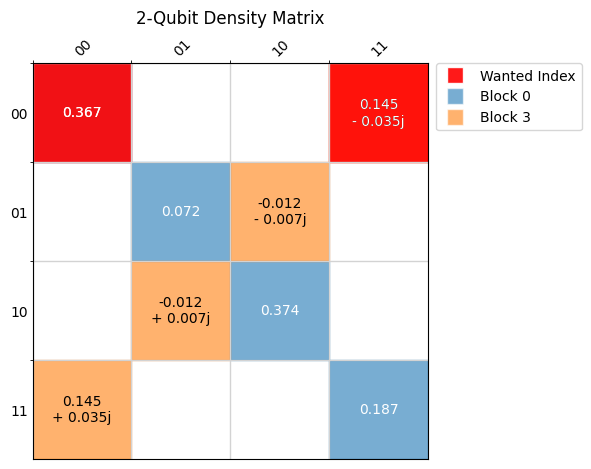

In [9]:
plot_rho(rho)          

In [10]:
rho_ideal

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.3772061 +0.j         -0.04165012+0.00872832j -0.0340766 -0.11647125j
   0.14758518-0.03297043j]
 [-0.04165012-0.00872832j  0.07399333+0.j          0.0010289 -0.00634918j
   0.00282704+0.01501647j]
 [-0.0340766 +0.11647125j  0.0010289 +0.00634918j  0.35891479+0.j
   0.02385341+0.17429884j]
 [ 0.14758518+0.03297043j  0.00282704-0.01501647j  0.02385341-0.17429884j
   0.18988578+0.j        ]]